# CAT VS DOG
[pytorch cat vs dog](https://www.kaggle.com/code/jaeboklee/pytorch-cat-vs-dog)

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image

%matplotlib inline

In [25]:
train_dir = './train/train'
test_dir = './test1/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)
test_files[0]

'1.jpg'

In [15]:
label = []
dog_n = 0
for fname in train_files:
    if fname.split('.')[0] == 'dog':
        label.append(1)
        dog_n += 1
    else:
        label.append(0)
        
print(f"the number of dog : {dog_n}\nthe number of cat : {len(train_files)-dog_n}")       
test_files[0:2]

the number of dog : 12500
the number of cat : 12500


['1.jpg', '10.jpg']

In [16]:
class CatDogDataset(Dataset):
    # __init__ : class가 호출되면 실행되는 코드
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    # 클래스의 인덱스로 접근시 실행
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)
print(type(cats))
catdogs = ConcatDataset([cats, dogs])
print(type(catdogs))

<class '__main__.CatDogDataset'>
<class 'torch.utils.data.dataset.ConcatDataset'>


In [17]:
dataloader = DataLoader(catdogs, batch_size = 32, shuffle=True)
print(type(dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


(Channel, H[130*3 + 2], W[130*8 + 2]) (3, 392, 1042)
(H[130*3 + 2], W[130*8 + 2], Channel) (392, 1042, 3)


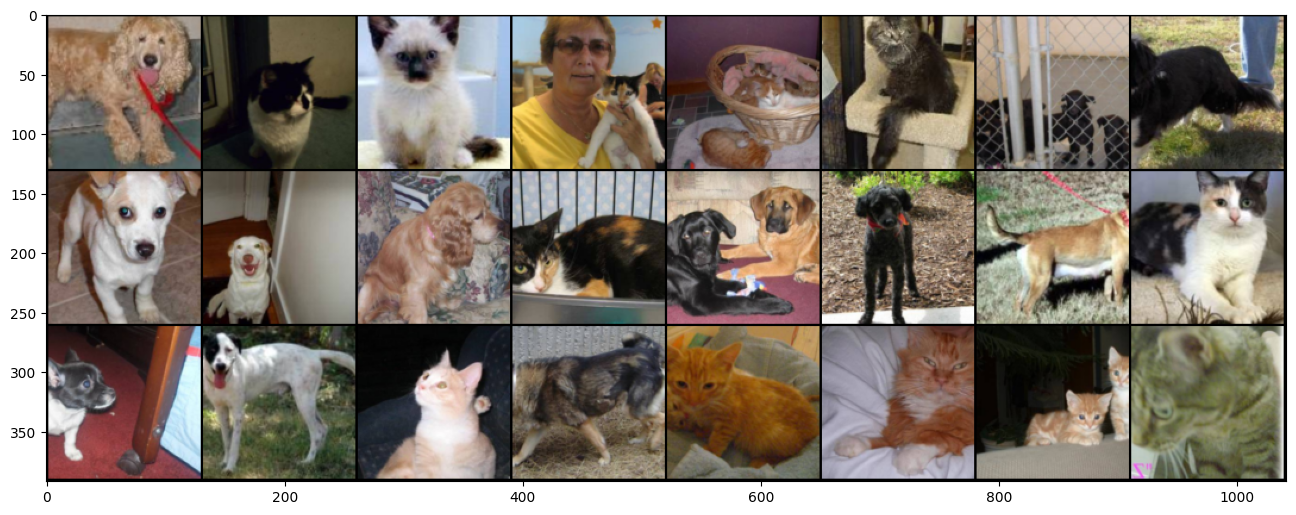

In [18]:
# dataloader에서 불러오기 위해 
samples, labels = next(iter(dataloader))

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
print("(Channel, H[130*3 + 2], W[130*8 + 2])",np_grid_imgs.shape)
print("(H[130*3 + 2], W[130*8 + 2], Channel)",np.transpose(np_grid_imgs, (1,2,0)).shape)
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
# 

In [19]:
# transfer learning
device = 'cpu'
model = torchvision.models.densenet121(pretrained=True)

![Alt text](image.png)

![Alt text](image-1.png)

In [20]:
# 불러온 모델의 마지막 부분(분류 부분)을 변경, 1024 -> 500, 500 -> 2개의 노드
num_ftrs = model.classifier.in_features
print(num_ftrs)
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

model = model.to(device)
# 손실함수, 옵티마이져, 스케쥴러(학습률 변화)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
# epoch 0~500 : lr 0.002
# epoch 500~1000 : lr 0.001
# epoch 1000~1500 : lr 0.0005
# epoch 1500~ : lr 0.00025
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

1024


[Epoch 1/3] Iteration 200 -> Train Loss: 0.5362, Accuracy: 0.812
[Epoch 1/3] Iteration 400 -> Train Loss: 0.3577, Accuracy: 0.781
[Epoch 1/3] Iteration 600 -> Train Loss: 0.2578, Accuracy: 0.906
[Epoch 2/3] Iteration 800 -> Train Loss: 0.2285, Accuracy: 1.000
[Epoch 2/3] Iteration 1000 -> Train Loss: 0.1879, Accuracy: 0.938
[Epoch 2/3] Iteration 1200 -> Train Loss: 0.1622, Accuracy: 1.000
[Epoch 2/3] Iteration 1400 -> Train Loss: 0.1581, Accuracy: 0.812
[Epoch 3/3] Iteration 1600 -> Train Loss: 0.1336, Accuracy: 0.969
[Epoch 3/3] Iteration 1800 -> Train Loss: 0.1181, Accuracy: 0.938
[Epoch 3/3] Iteration 2000 -> Train Loss: 0.1130, Accuracy: 0.906
[Epoch 3/3] Iteration 2200 -> Train Loss: 0.1042, Accuracy: 1.000


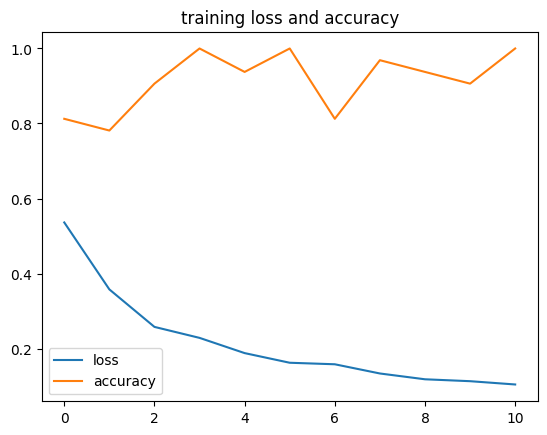

In [21]:
epochs = 3
itr = 1
p_itr = 200
model.train()

total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    # dataloader에서 배치단위로 하나씩 나온다.
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        # 그레이디언트를 0으로 초기화
        optimizer.zero_grad()
        output = model(samples)
        #CrossEntropyLoss
        loss = criterion(output, labels)
        loss.backward()
        # Adam
        optimizer.step()
        total_loss += loss.item()
        #스케쥴러(학습률 변화)
        scheduler.step()
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [22]:
# 가중치 저장
filename_pth = 'ckpt_densenet121_catdog.pth'
torch.save(model.state_dict(), filename_pth)

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False)

In [23]:
# 학습이 끝난 모델의 추론모드
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

# 제출 파일 저장
submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('preds_densenet121.csv', index=False)

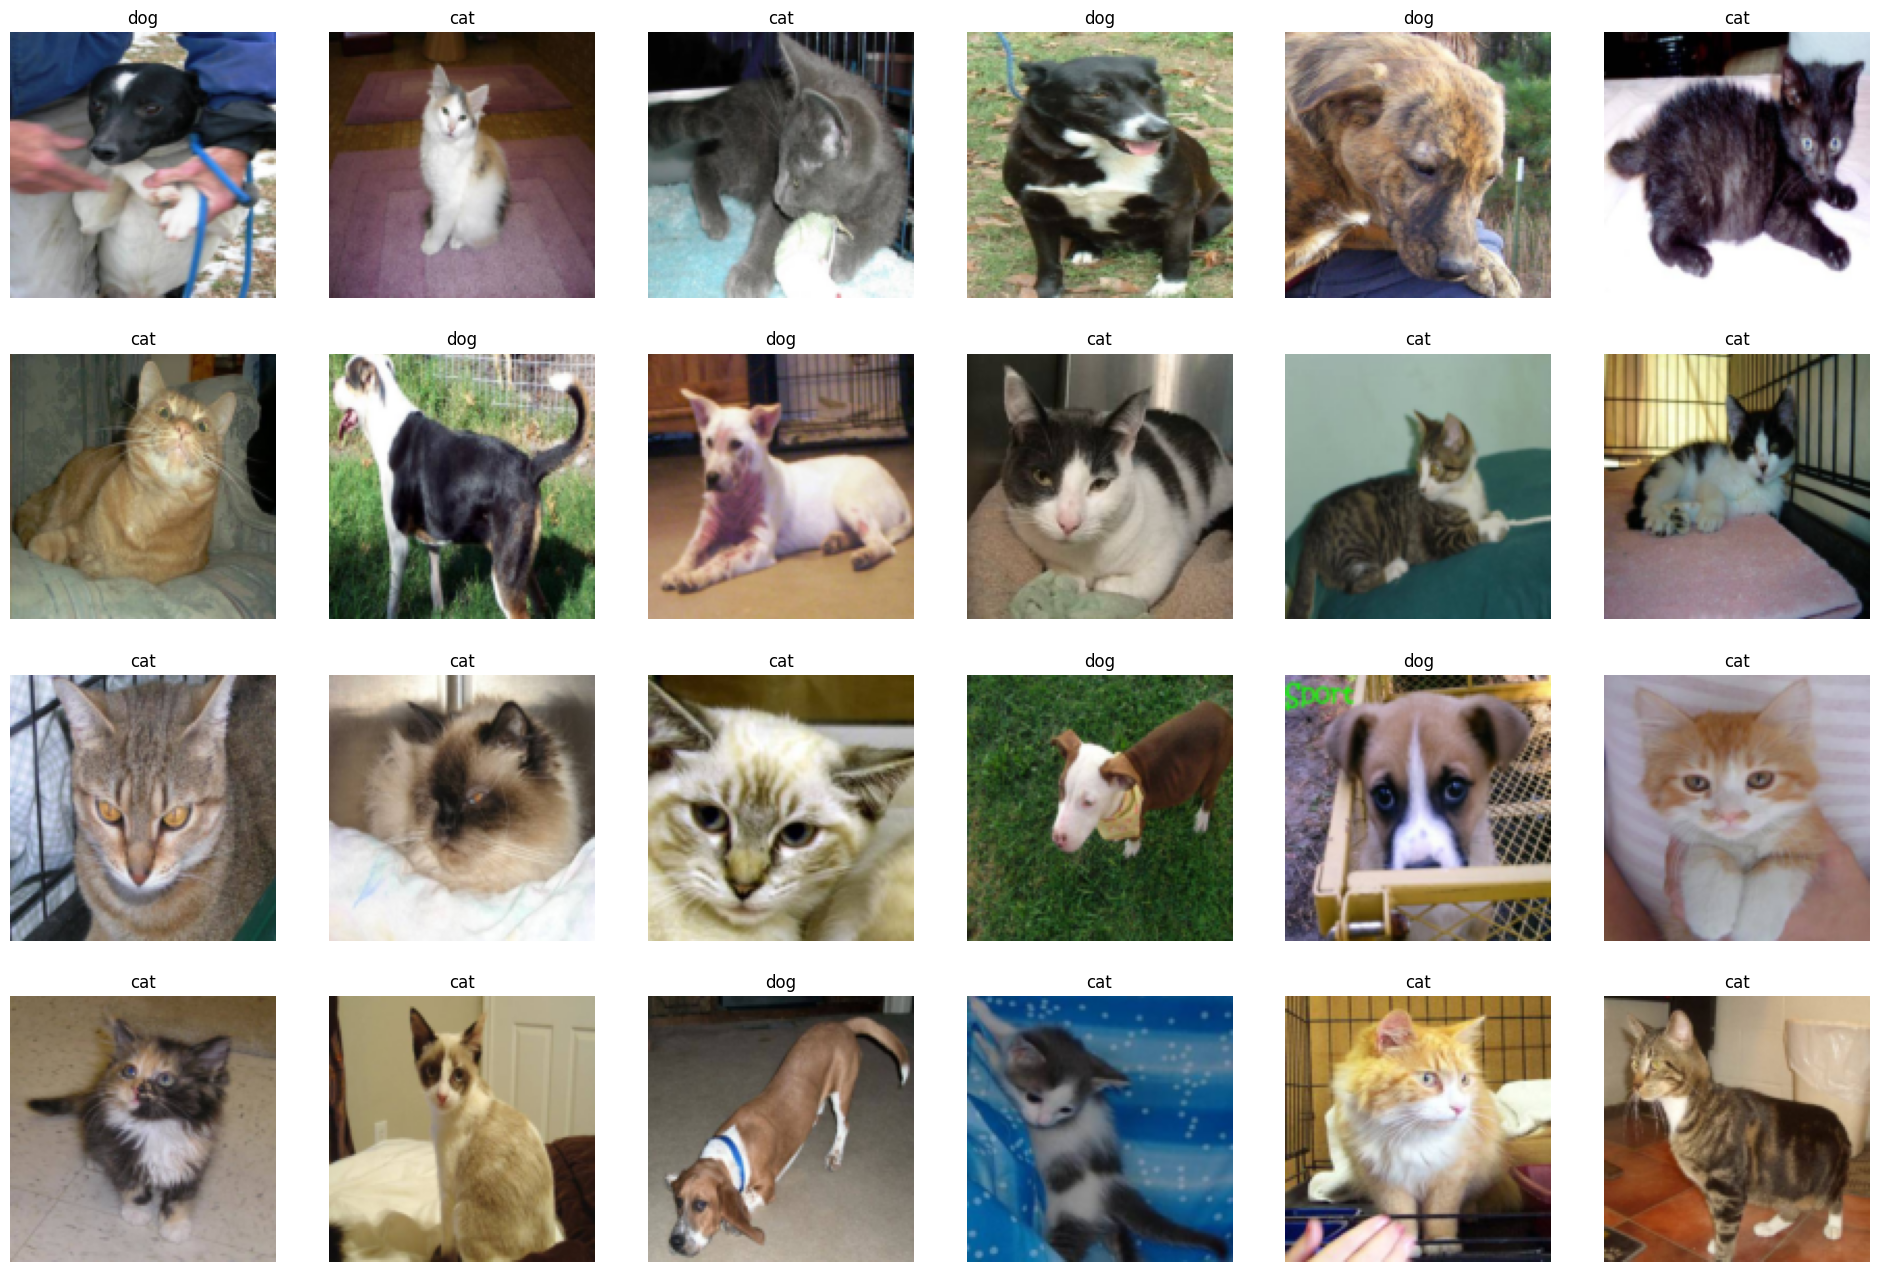

In [24]:
samples, _ = next(iter(testloader))
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))